In [24]:
import pandas as pd


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(42)

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

print("Librerías importadas correctamente")
print("Semilla aleatoria configurada en 42 para reproducibilidad")
print("Variables numéricas objetivo: age, education_num, capital_neto, hours_per_week")
print("Métricas de evaluación: Silhouette Score y Davies-Bouldin Index")
print("Feature engineering: capital_neto = capital_gain - capital_loss")


Librerías importadas correctamente
Semilla aleatoria configurada en 42 para reproducibilidad
Variables numéricas objetivo: age, education_num, capital_neto, hours_per_week
Métricas de evaluación: Silhouette Score y Davies-Bouldin Index
Feature engineering: capital_neto = capital_gain - capital_loss


In [26]:
print("SECCIÓN 2: CARGA Y LIMPIEZA DE DATOS")
print("="*50)


print("Cargando dataset Adult Census...")
df = pd.read_csv('../../../datos/adult.data', names=column_names, na_values=' ?')

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

print(f"\nInformación del dataset:")
print(f"  Columnas: {list(df.columns)}")
print(f"  Tipos de datos:")
for col in df.columns:
    print(f"    {col}: {df[col].dtype}")

print(f"\nValores faltantes por columna:")
missing_values = df.isnull().sum()
for col, missing in missing_values.items():
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(df)*100:.1f}%)")

print(f"\nRealizando limpieza básica...")

df_clean = df.dropna().copy()
print(f"  Registros después de eliminar faltantes: {len(df_clean)}")

df_clean = df_clean.drop_duplicates().copy()
print(f"  Registros después de eliminar duplicados: {len(df_clean)}")


df_clean['income_binary'] = (df_clean['income'] == ' >50K').astype(int)

print(f"\nDistribución de income:")
income_dist = df_clean['income'].value_counts()
for income, count in income_dist.items():
    print(f"  {income}: {count} ({count/len(df_clean)*100:.1f}%)")

print(f"\nDistribución de income_binary:")
income_binary_dist = df_clean['income_binary'].value_counts()
for binary, count in income_binary_dist.items():
    print(f"  {binary}: {count} ({count/len(df_clean)*100:.1f}%)")

numerical_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
print(f"\nVariables numéricas objetivo:")
for var in numerical_vars:
    print(f"  {var}: {df_clean[var].dtype}, rango [{df_clean[var].min()}, {df_clean[var].max()}]")


print("Dataset cargado y limpiado")


SECCIÓN 2: CARGA Y LIMPIEZA DE DATOS
Cargando dataset Adult Census...
Dataset cargado: 32561 registros, 15 columnas

Información del dataset:
  Columnas: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
  Tipos de datos:
    age: int64
    workclass: object
    fnlwgt: int64
    education: object
    education_num: int64
    marital_status: object
    occupation: object
    relationship: object
    race: object
    sex: object
    capital_gain: int64
    capital_loss: int64
    hours_per_week: int64
    native_country: object
    income: object

Valores faltantes por columna:
  workclass: 1836 (5.6%)
  occupation: 1843 (5.7%)
  native_country: 583 (1.8%)

Realizando limpieza básica...
  Registros después de eliminar faltantes: 30162
  Registros después de eliminar duplicados: 30139

Distribución de income:
   <=50K: 22633 (75.1%)
   >5

SECCIÓN 3: EXPLORACIÓN DE VARIABLES NUMÉRICAS
Variables numéricas a analizar: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Nota: capital_gain y capital_loss se usarán para crear capital_neto

ESTADÍSTICAS DESCRIPTIVAS:
----------------------------------------
            age  education_num  capital_gain  capital_loss  hours_per_week
count  30139.00       30139.00      30139.00      30139.00        30139.00
mean      38.44          10.12       1092.84         88.44           40.93
std       13.13           2.55       7409.11        404.45           11.98
min       17.00           1.00          0.00          0.00            1.00
25%       28.00           9.00          0.00          0.00           40.00
50%       37.00          10.00          0.00          0.00           40.00
75%       47.00          13.00          0.00          0.00           45.00
max       90.00          16.00      99999.00       4356.00           99.00

ANÁLISIS DE DISTRIBUCIONES:
------

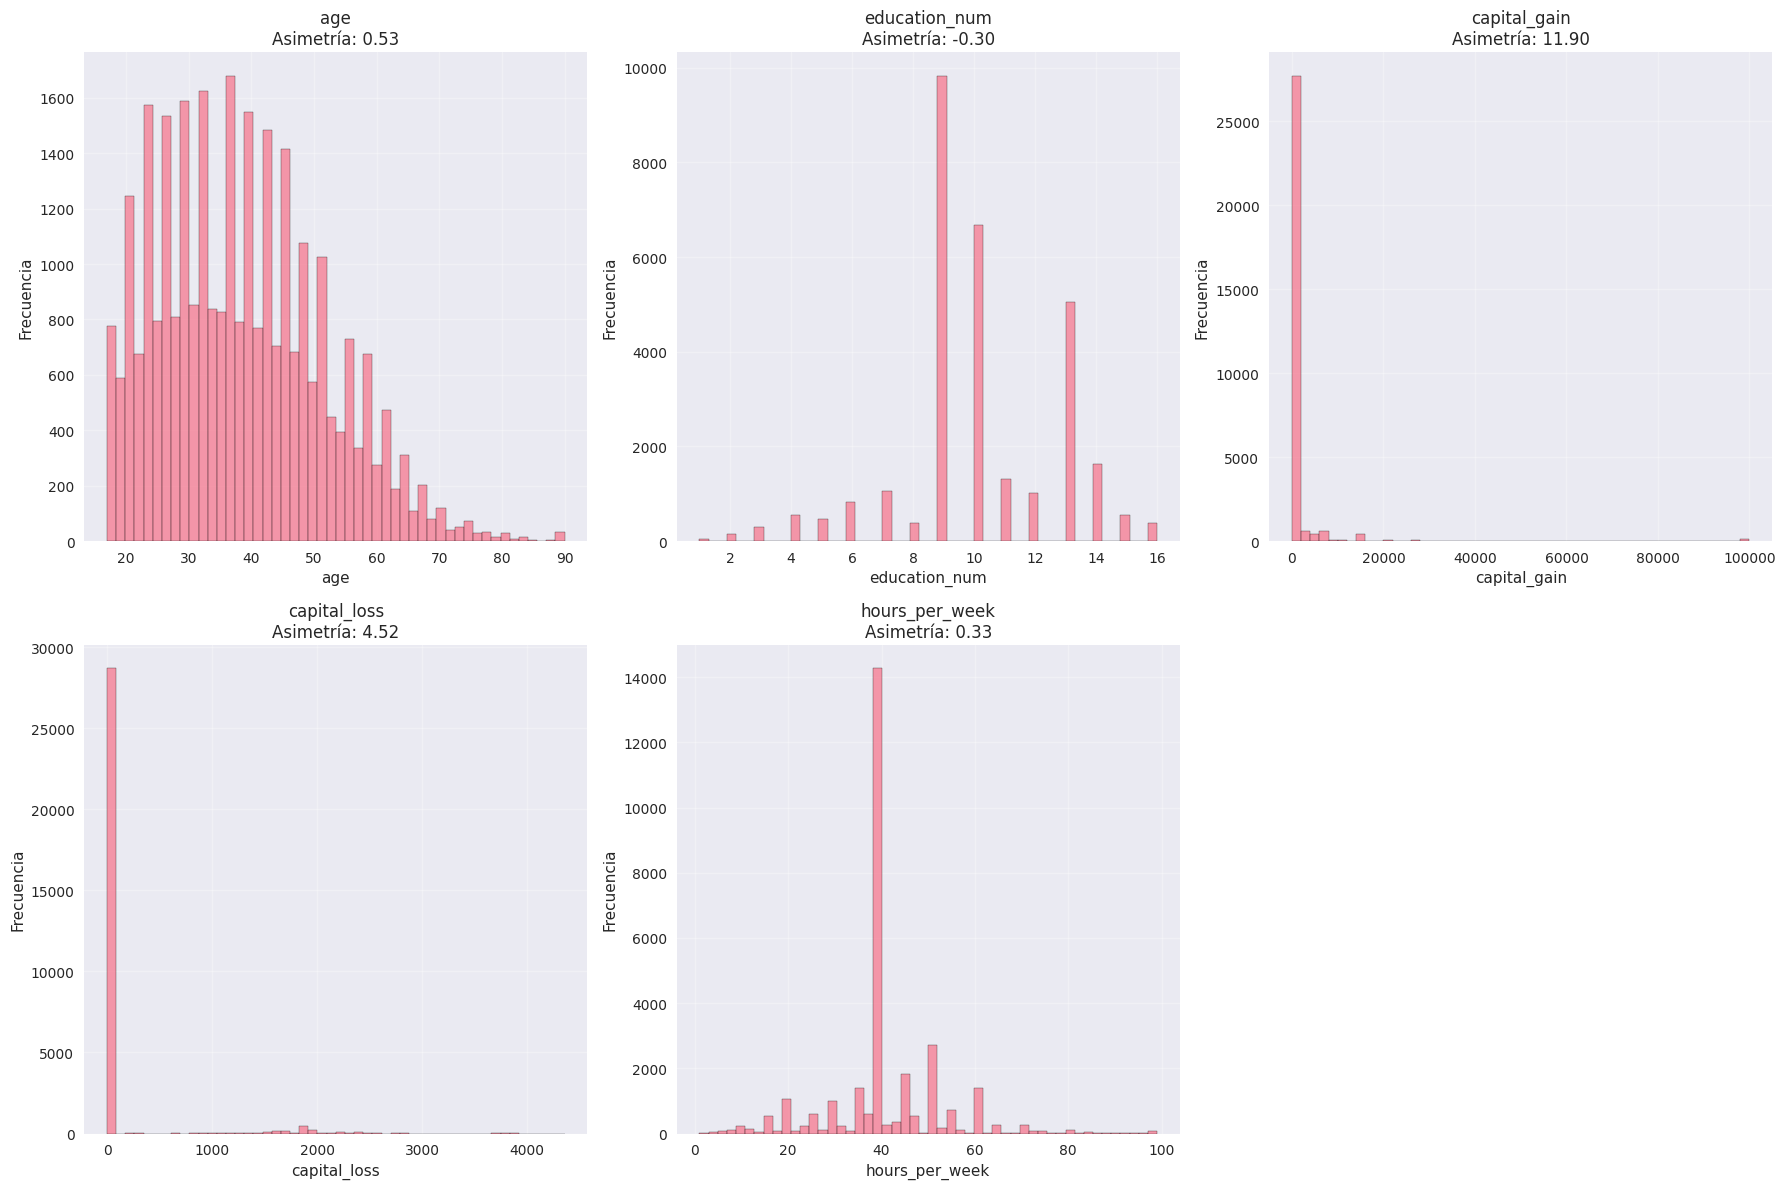


ANÁLISIS DE OUTLIERS:
----------------------------------------
age:
  Límites: [-0.5, 75.5]
  Outliers: 168 (0.6%)
education_num:
  Límites: [3.0, 19.0]
  Outliers: 193 (0.6%)
capital_gain:
  Límites: [0.0, 0.0]
  Outliers: 2538 (8.4%)
capital_loss:
  Límites: [0.0, 0.0]
  Outliers: 1427 (4.7%)
hours_per_week:
  Límites: [32.5, 52.5]
  Outliers: 7947 (26.4%)

MATRIZ DE CORRELACIONES:
----------------------------------------
                  age  education_num  capital_gain  capital_loss  \
age             1.000          0.043         0.080         0.060   
education_num   0.043          1.000         0.124         0.080   
capital_gain    0.080          0.124         1.000        -0.032   
capital_loss    0.060          0.080        -0.032         1.000   
hours_per_week  0.101          0.153         0.080         0.052   

                hours_per_week  
age                      0.101  
education_num            0.153  
capital_gain             0.080  
capital_loss             0.052

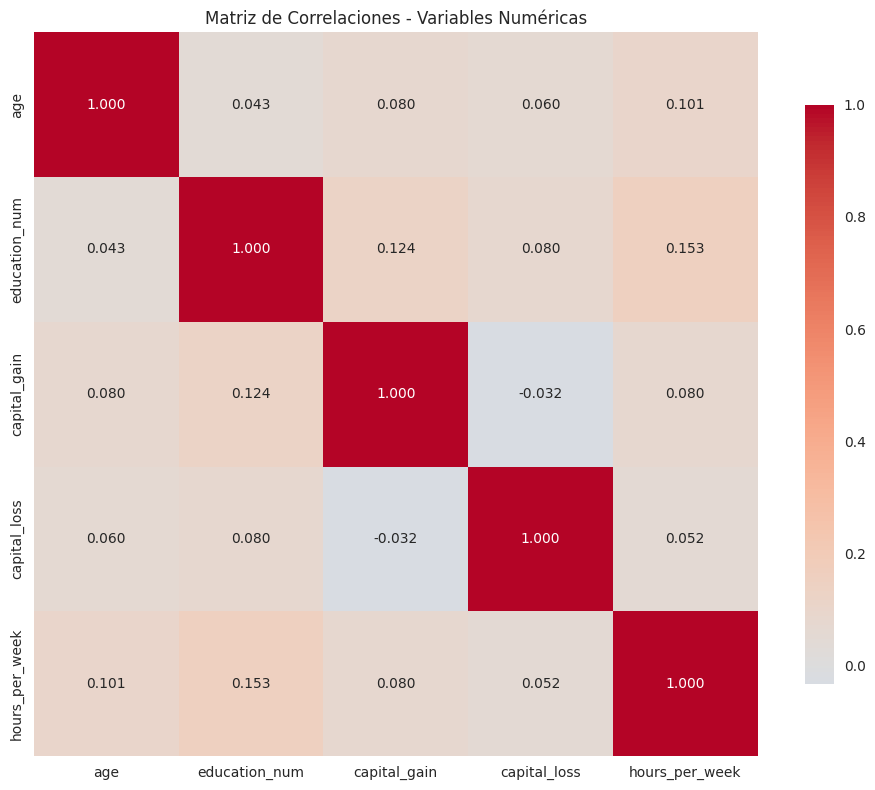


CORRELACIONES CON INCOME_BINARY:
----------------------------------------
Correlación con income_binary:
  age: 0.242
  education_num: 0.335
  capital_gain: 0.221
  capital_loss: 0.150
  hours_per_week: 0.229


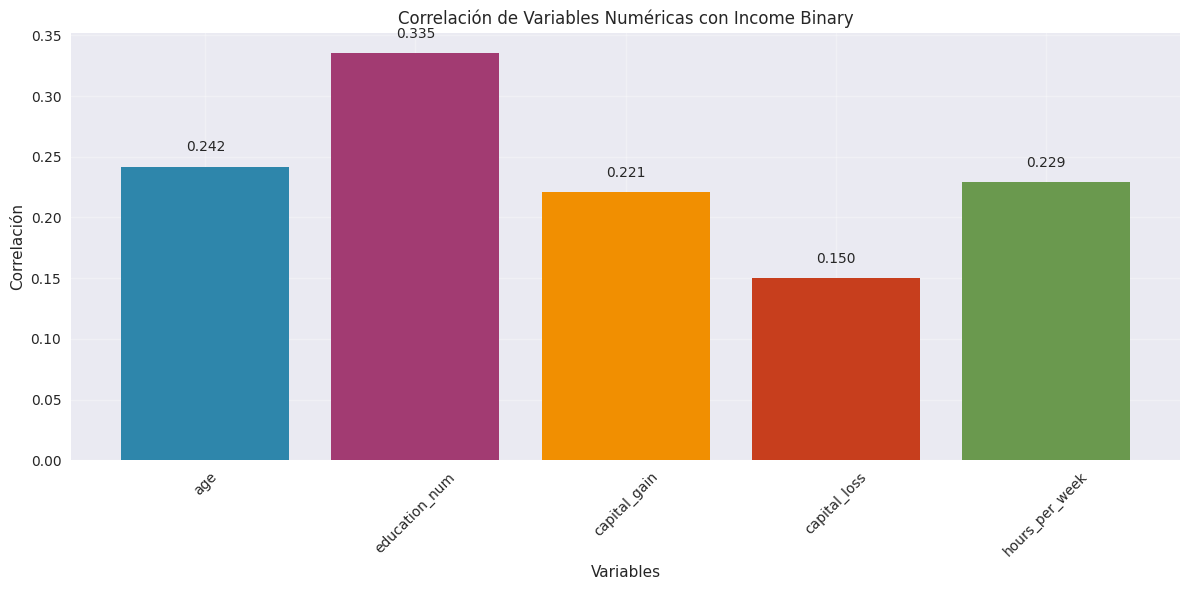

In [27]:

print("SECCIÓN 3: EXPLORACIÓN DE VARIABLES NUMÉRICAS")
print("="*50)

numerical_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

print(f"Variables numéricas a analizar: {numerical_vars}")
print("Nota: capital_gain y capital_loss se usarán para crear capital_neto")


print(f"\nESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 40)
desc_stats = df_clean[numerical_vars].describe()
print(desc_stats.round(2))

print(f"\nANÁLISIS DE DISTRIBUCIONES:")
print("-" * 40)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, var in enumerate(numerical_vars):

    mean_val = df_clean[var].mean()
    std_val = df_clean[var].std()
    skewness = df_clean[var].skew()
    kurtosis = df_clean[var].kurtosis()
    
    print(f"\n{var}:")
    print(f"  Media: {mean_val:.2f}, Desv. Estándar: {std_val:.2f}")
    print(f"  Asimetría: {skewness:.2f}, Curtosis: {kurtosis:.2f}")
    
    
    if abs(skewness) < 0.5:
        dist_type = "Simétrica"
    elif abs(skewness) < 1.0:
        dist_type = "Ligeramente sesgada"
    else:
        dist_type = "Muy sesgada"
    
    print(f"  Tipo de distribución: {dist_type}")
    
    
    axes[i].hist(df_clean[var], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{var}\nAsimetría: {skewness:.2f}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)


if len(numerical_vars) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


print(f"\nANÁLISIS DE OUTLIERS:")
print("-" * 40)

for var in numerical_vars:
    Q1 = df_clean[var].quantile(0.25)
    Q3 = df_clean[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[var] < lower_bound) | (df_clean[var] > upper_bound)]
    outlier_pct = len(outliers) / len(df_clean) * 100
    
    print(f"{var}:")
    print(f"  Límites: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Outliers: {len(outliers)} ({outlier_pct:.1f}%)")
print(f"\nMATRIZ DE CORRELACIONES:")
print("-" * 40)

correlation_matrix = df_clean[numerical_vars].corr()
print(correlation_matrix.round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlaciones - Variables Numéricas')
plt.tight_layout()
plt.show()

print(f"\nCORRELACIONES CON INCOME_BINARY:")
print("-" * 40)

income_correlations = df_clean[numerical_vars + ['income_binary']].corr()['income_binary'].drop('income_binary')
print("Correlación con income_binary:")
for var, corr in income_correlations.items():
    print(f"  {var}: {corr:.3f}")

plt.figure(figsize=(12, 6))
bars = plt.bar(numerical_vars, income_correlations.values, 
               color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E'])
plt.title('Correlación de Variables Numéricas con Income Binary')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


for bar, corr in zip(bars, income_correlations.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{corr:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


SECCIÓN 4: FEATURE ENGINEERING - CAPITAL_NETO
Creando variable capital_neto...
Variable capital_neto creada: capital_gain - capital_loss

ANÁLISIS DE CAPITAL_NETO:
----------------------------------------
Estadísticas de capital_neto:
count    30139.00
mean      1004.40
std       7433.16
min      -4356.00
25%          0.00
50%          0.00
75%          0.00
max      99999.00
Name: capital_neto, dtype: float64

Distribución de capital_neto:
Top 10 valores más frecuentes:
  0: 26174 (86.8%)
  15024: 337 (1.1%)
  7688: 270 (0.9%)
  7298: 240 (0.8%)
  -1902: 194 (0.6%)
  -1977: 162 (0.5%)
  -1887: 155 (0.5%)
  99999: 148 (0.5%)
  3103: 94 (0.3%)
  5178: 91 (0.3%)

CASOS ESPECIALES:
----------------------------------------
Casos con capital_gain > 0 Y capital_loss > 0: 0 (0.0%)
Casos con capital_neto < 0: 1427 (4.7%)
Casos con capital_neto = 0: 26174 (86.8%)

Creando visualizaciones comparativas...


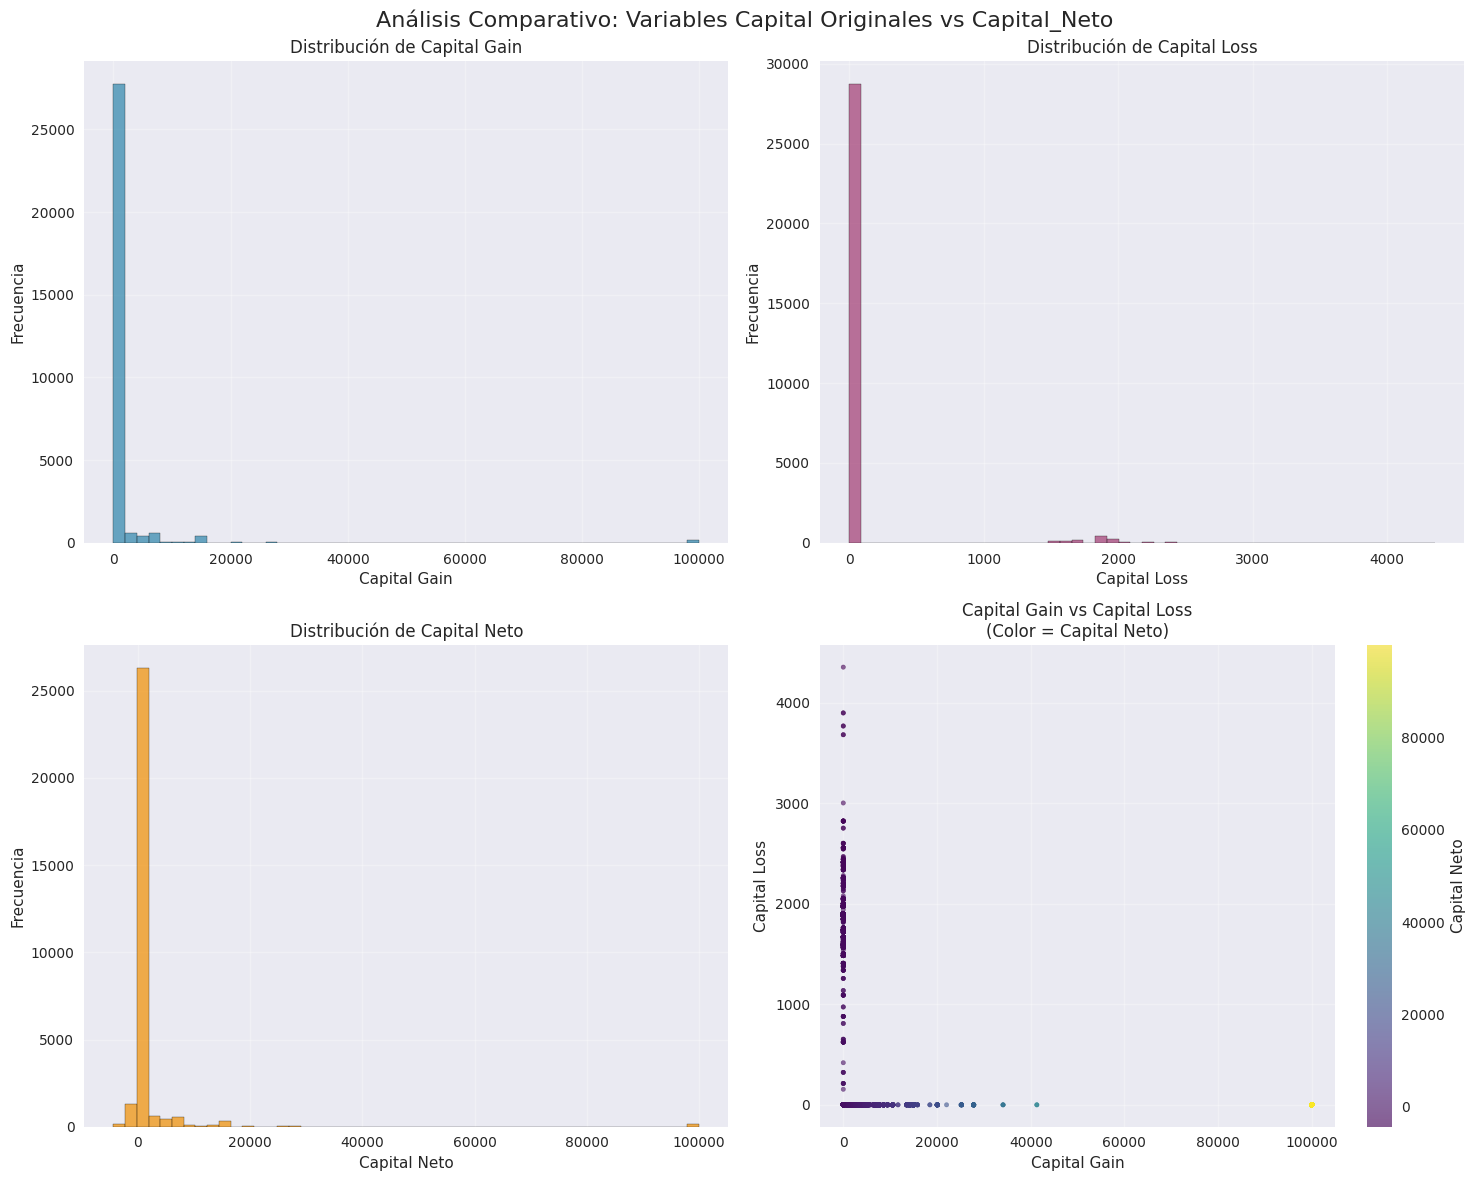


ANÁLISIS DE CORRELACIONES:
----------------------------------------
Correlación con income_binary:
  capital_gain: 0.221
  capital_loss: 0.150
  capital_neto: 0.212

Correlaciones entre variables capital:
              capital_gain  capital_loss  capital_neto
capital_gain         1.000        -0.032         0.999
capital_loss        -0.032         1.000        -0.087
capital_neto         0.999        -0.087         1.000

VARIABLES FINALES PARA K-MEANS:
----------------------------------------
Variables finales (4 variables): ['age', 'education_num', 'capital_neto', 'hours_per_week']
Variables eliminadas: capital_gain, capital_loss
Variable creada: capital_neto = capital_gain - capital_loss


In [28]:
print("SECCIÓN 4: FEATURE ENGINEERING - CAPITAL_NETO")
print("="*50)


print("Creando variable capital_neto...")
df_clean['capital_neto'] = df_clean['capital_gain'] - df_clean['capital_loss']

print(f"Variable capital_neto creada: capital_gain - capital_loss")

print(f"\nANÁLISIS DE CAPITAL_NETO:")
print("-" * 40)

capital_neto_stats = df_clean['capital_neto'].describe()
print("Estadísticas de capital_neto:")
print(capital_neto_stats.round(2))


print(f"\nDistribución de capital_neto:")
capital_neto_dist = df_clean['capital_neto'].value_counts().head(10)
print("Top 10 valores más frecuentes:")
for value, count in capital_neto_dist.items():
    print(f"  {value}: {count} ({count/len(df_clean)*100:.1f}%)")

print(f"\nCASOS ESPECIALES:")
print("-" * 40)


both_positive = df_clean[(df_clean['capital_gain'] > 0) & (df_clean['capital_loss'] > 0)]
print(f"Casos con capital_gain > 0 Y capital_loss > 0: {len(both_positive)} ({len(both_positive)/len(df_clean)*100:.1f}%)")

negative_neto = df_clean[df_clean['capital_neto'] < 0]
print(f"Casos con capital_neto < 0: {len(negative_neto)} ({len(negative_neto)/len(df_clean)*100:.1f}%)")

zero_neto = df_clean[df_clean['capital_neto'] == 0]
print(f"Casos con capital_neto = 0: {len(zero_neto)} ({len(zero_neto)/len(df_clean)*100:.1f}%)")

print(f"\nCreando visualizaciones comparativas...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Comparativo: Variables Capital Originales vs Capital_Neto', fontsize=16)

axes[0, 0].hist(df_clean['capital_gain'], bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
axes[0, 0].set_title('Distribución de Capital Gain')
axes[0, 0].set_xlabel('Capital Gain')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df_clean['capital_loss'], bins=50, alpha=0.7, color='#A23B72', edgecolor='black')
axes[0, 1].set_title('Distribución de Capital Loss')
axes[0, 1].set_xlabel('Capital Loss')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df_clean['capital_neto'], bins=50, alpha=0.7, color='#F18F01', edgecolor='black')
axes[1, 0].set_title('Distribución de Capital Neto')
axes[1, 0].set_xlabel('Capital Neto')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(True, alpha=0.3)


scatter = axes[1, 1].scatter(df_clean['capital_gain'], df_clean['capital_loss'], 
                            c=df_clean['capital_neto'], cmap='viridis', alpha=0.6, s=10)
axes[1, 1].set_title('Capital Gain vs Capital Loss\n(Color = Capital Neto)')
axes[1, 1].set_xlabel('Capital Gain')
axes[1, 1].set_ylabel('Capital Loss')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Capital Neto')

plt.tight_layout()
plt.show()


print(f"\nANÁLISIS DE CORRELACIONES:")
print("-" * 40)


correlations_with_income = df_clean[['capital_gain', 'capital_loss', 'capital_neto', 'income_binary']].corr()['income_binary'].drop('income_binary')
print("Correlación con income_binary:")
for var, corr in correlations_with_income.items():
    print(f"  {var}: {corr:.3f}")

capital_correlations = df_clean[['capital_gain', 'capital_loss', 'capital_neto']].corr()
print(f"\nCorrelaciones entre variables capital:")
print(capital_correlations.round(3))

print(f"\nVARIABLES FINALES PARA K-MEANS:")
print("-" * 40)

final_vars = ['age', 'education_num', 'capital_neto', 'hours_per_week']

print(f"Variables finales (4 variables): {final_vars}")
print("Variables eliminadas: capital_gain, capital_loss")
print("Variable creada: capital_neto = capital_gain - capital_loss")

SECCIÓN 5: NORMALIZACIÓN DE VARIABLES
Variables finales: ['age', 'education_num', 'capital_neto', 'hours_per_week']

ANÁLISIS DE DISTRIBUCIONES PARA NORMALIZACIÓN:
--------------------------------------------------
Variables para StandardScaler: ['age', 'hours_per_week']
Variables para MinMaxScaler: ['education_num', 'capital_neto']

Preparando datos para normalización...
Dataset final: (30139, 4)
Normalización aplicada:
  StandardScaler: ['age', 'hours_per_week']
  MinMaxScaler: ['education_num', 'capital_neto']

VERIFICACIÓN DE NORMALIZACIÓN:
--------------------------------------------------
  age (StandardScaler): [-1.633, 3.926], media=0.000, std=1.000
  education_num (MinMaxScaler): [0.000, 1.000], media=0.608, std=0.170
  capital_neto (MinMaxScaler): [0.000, 1.000], media=0.051, std=0.071
  hours_per_week (StandardScaler): [-3.334, 4.847], media=-0.000, std=1.000

Creando visualizaciones de distribuciones normalizadas...


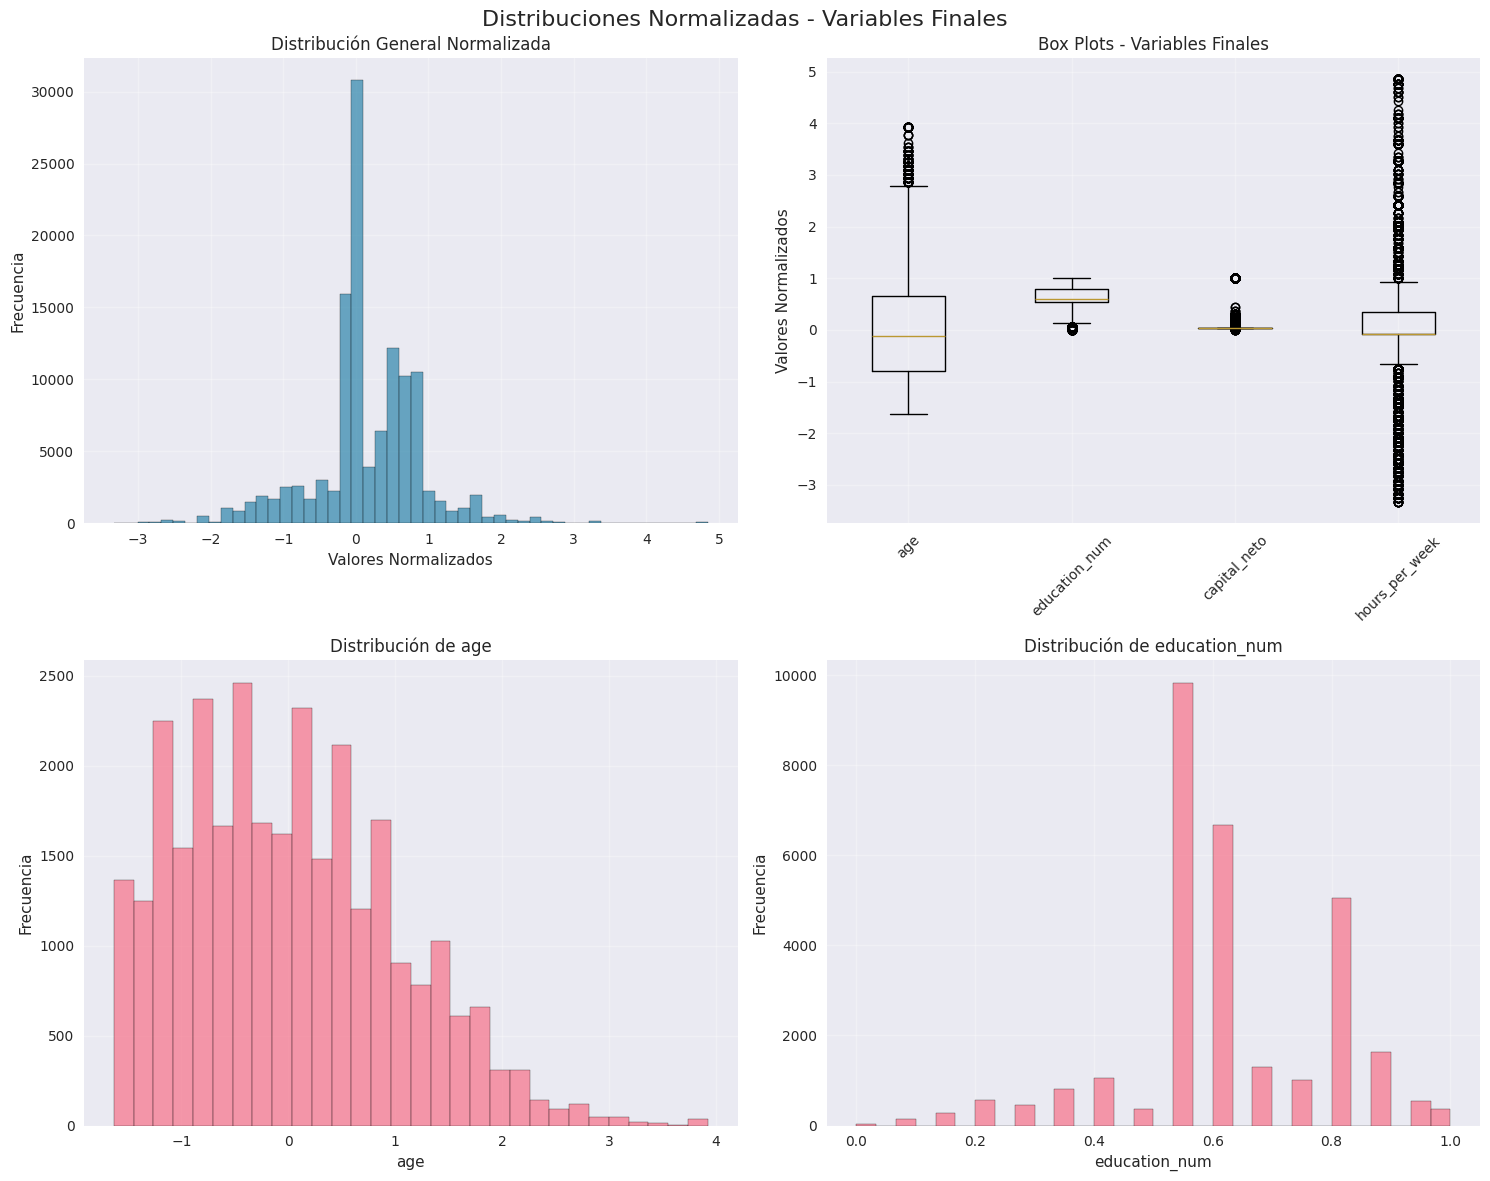


Verificando valores faltantes:
  Dataset final: 0 valores faltantes

Verificando valores infinitos:
  Dataset final: 0 valores infinitos


In [29]:
print("SECCIÓN 5: NORMALIZACIÓN DE VARIABLES")
print("="*50)


print(f"Variables finales: {final_vars}")


print(f"\nANÁLISIS DE DISTRIBUCIONES PARA NORMALIZACIÓN:")
print("-" * 50)


standard_vars = ['age', 'hours_per_week']

minmax_vars = ['education_num', 'capital_neto']

print(f"Variables para StandardScaler: {standard_vars}")
print(f"Variables para MinMaxScaler: {minmax_vars}")

print(f"\nPreparando datos para normalización...")

X_final = df_clean[final_vars].copy()
print(f"Dataset final: {X_final.shape}")

scaler_standard = StandardScaler()
X_final[standard_vars] = scaler_standard.fit_transform(X_final[standard_vars])

scaler_minmax = MinMaxScaler()
X_final[minmax_vars] = scaler_minmax.fit_transform(X_final[minmax_vars])

print(f"Normalización aplicada:")
print(f"  StandardScaler: {standard_vars}")
print(f"  MinMaxScaler: {minmax_vars}")

print(f"\nVERIFICACIÓN DE NORMALIZACIÓN:")
print("-" * 50)

for var in final_vars:
    min_val = X_final[var].min()
    max_val = X_final[var].max()
    mean_val = X_final[var].mean()
    std_val = X_final[var].std()
    
    if var in standard_vars:
        print(f"  {var} (StandardScaler): [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")
    else:
        print(f"  {var} (MinMaxScaler): [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")

print(f"\nCreando visualizaciones de distribuciones normalizadas...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuciones Normalizadas - Variables Finales', fontsize=16)

axes[0, 0].hist(X_final.values.flatten(), bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
axes[0, 0].set_title('Distribución General Normalizada')
axes[0, 0].set_xlabel('Valores Normalizados')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([X_final[var] for var in final_vars], labels=final_vars)
axes[0, 1].set_title('Box Plots - Variables Finales')
axes[0, 1].set_ylabel('Valores Normalizados')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)


for i, var in enumerate(final_vars):
    if i < 2:  
        axes[1, i].hist(X_final[var], bins=30, alpha=0.7, edgecolor='black')
        axes[1, i].set_title(f'Distribución de {var}')
        axes[1, i].set_xlabel(var)
        axes[1, i].set_ylabel('Frecuencia')
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVerificando valores faltantes:")
print(f"  Dataset final: {X_final.isnull().sum().sum()} valores faltantes")


print(f"\nVerificando valores infinitos:")
print(f"  Dataset final: {np.isinf(X_final.values).sum()} valores infinitos")

In [30]:
print("SECCIÓN 6: CREACIÓN DE MUESTRAS REPRODUCIBLES")
print("="*50)


print("Creando muestras reproducibles...")

sample_5k = df_clean.sample(n=5000, random_state=42)
print(f"Muestra 5K: {len(sample_5k)} registros")

sample_10k = df_clean.sample(n=10000, random_state=42)
print(f"Muestra 10K: {len(sample_10k)} registros")


print(f"\nPreparando DataFrames normalizados...")


X_5k = sample_5k[final_vars].copy()

X_5k[standard_vars] = scaler_standard.transform(sample_5k[standard_vars])
X_5k[minmax_vars] = scaler_minmax.transform(sample_5k[minmax_vars])


X_10k = sample_10k[final_vars].copy()

X_10k[standard_vars] = scaler_standard.transform(sample_10k[standard_vars])
X_10k[minmax_vars] = scaler_minmax.transform(sample_10k[minmax_vars])

print(f"DataFrames normalizados creados:")
print(f"  Muestra 5K: {X_5k.shape}")
print(f"  Muestra 10K: {X_10k.shape}")


SECCIÓN 6: CREACIÓN DE MUESTRAS REPRODUCIBLES
Creando muestras reproducibles...
Muestra 5K: 5000 registros
Muestra 10K: 10000 registros

Preparando DataFrames normalizados...
DataFrames normalizados creados:
  Muestra 5K: (5000, 4)
  Muestra 10K: (10000, 4)


SECCIÓN 7: K-MEANS CON VARIABLES FINALES - MUESTRA 5K
Probando valores de k: [2, 3, 4, 5, 6, 7, 8, 9, 10]

Aplicando K-means a muestra 5K...
Probando k=2...
  Silhouette: 0.3517, Davies-Bouldin: 1.1138, Tiempo: 0.17s
Probando k=3...
  Silhouette: 0.3864, Davies-Bouldin: 0.9133, Tiempo: 0.18s
Probando k=4...
  Silhouette: 0.4033, Davies-Bouldin: 0.8262, Tiempo: 0.13s
Probando k=5...
  Silhouette: 0.4189, Davies-Bouldin: 0.7633, Tiempo: 0.18s
Probando k=6...
  Silhouette: 0.3695, Davies-Bouldin: 0.8214, Tiempo: 0.21s
Probando k=7...
  Silhouette: 0.3772, Davies-Bouldin: 0.8381, Tiempo: 0.31s
Probando k=8...
  Silhouette: 0.3910, Davies-Bouldin: 0.7880, Tiempo: 0.20s
Probando k=9...
  Silhouette: 0.3558, Davies-Bouldin: 0.8141, Tiempo: 0.16s
Probando k=10...
  Silhouette: 0.3590, Davies-Bouldin: 0.8029, Tiempo: 0.30s

K óptimo según Silhouette: 5 (score: 0.4189)
K óptimo según Davies-Bouldin: 5 (score: 0.7633)

Creando visualizaciones...


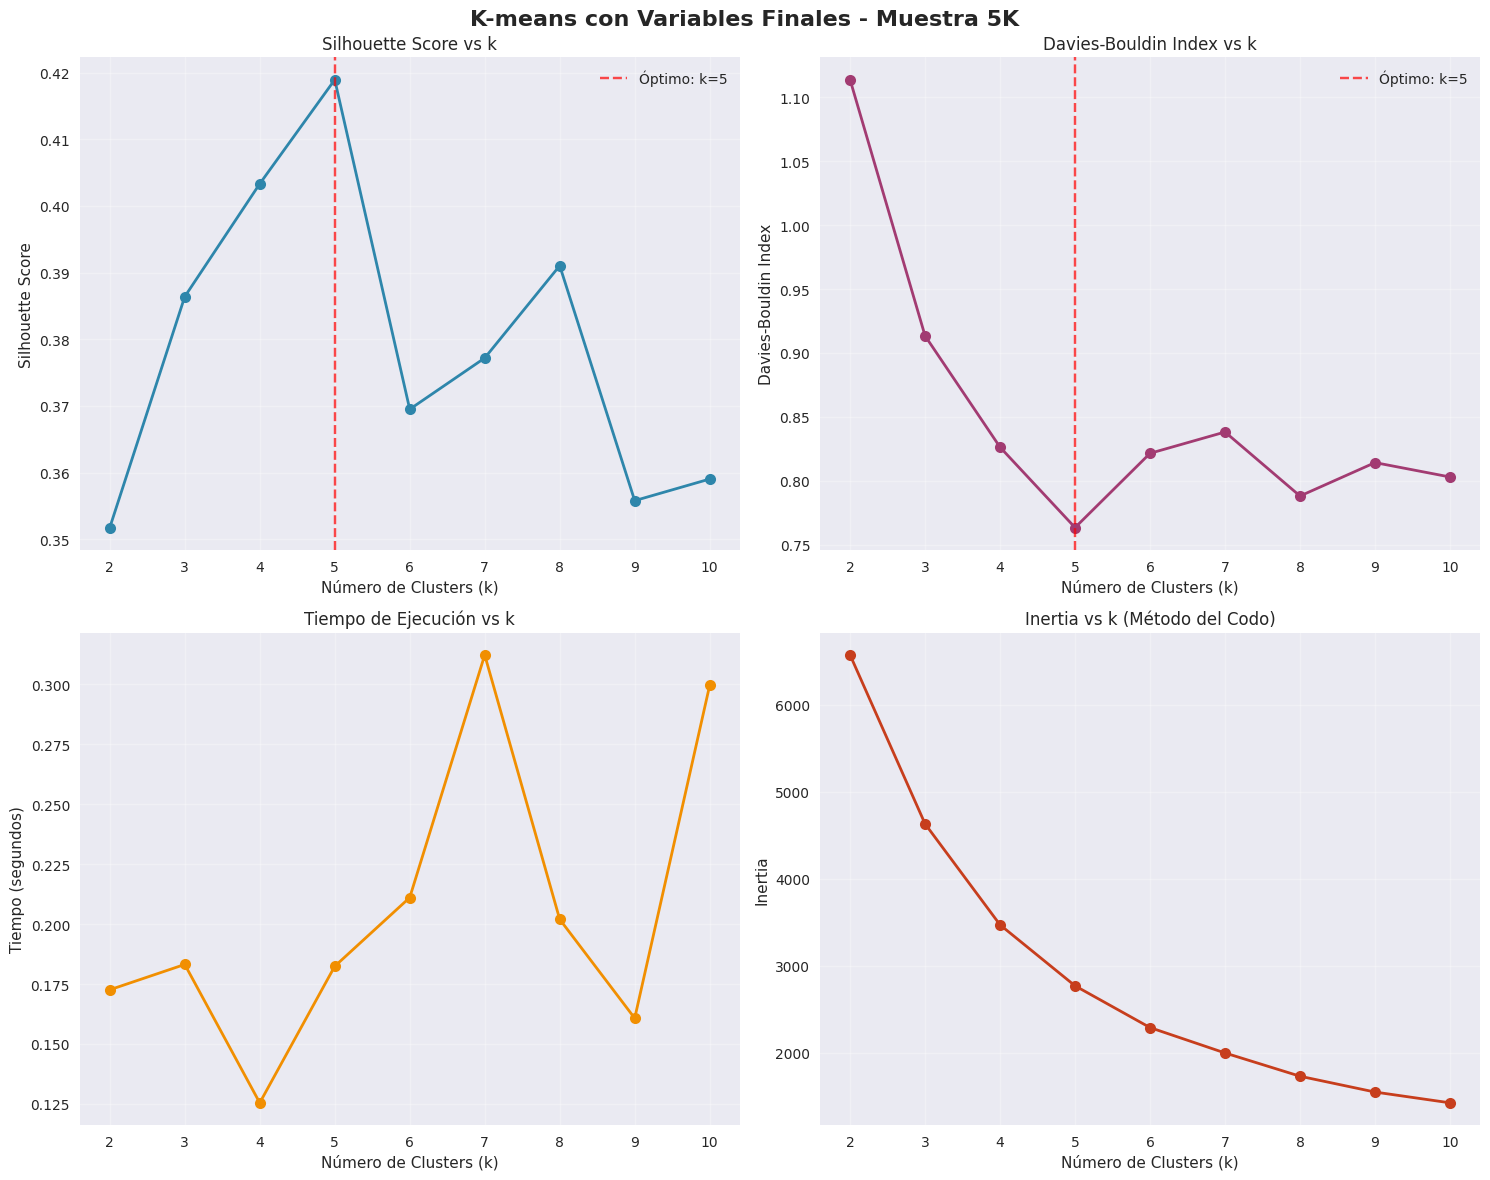


Creando scatter plot de clusters (k óptimo = 5)...


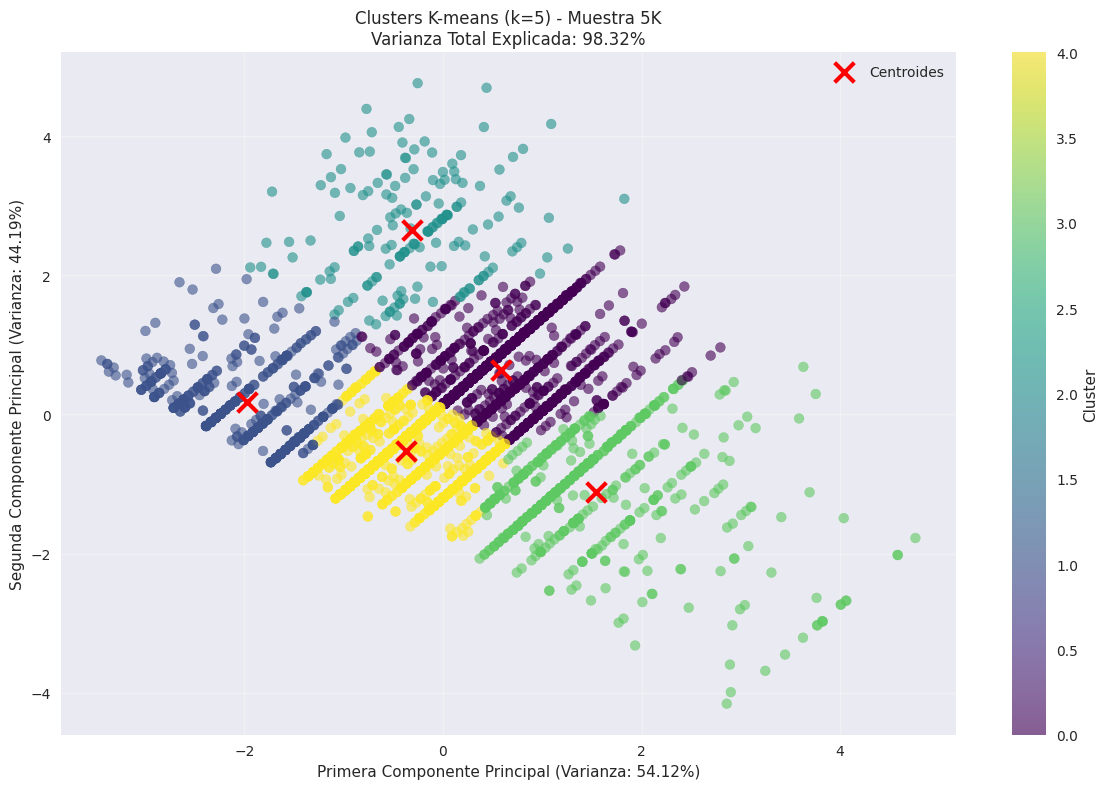


ANÁLISIS DE PATRONES EN CLUSTERS (k=5):
--------------------------------------------------

Cluster 0 (1739 registros):
  Edad promedio: 49.6
  Educación promedio: 10.2
  Horas/semana promedio: 41.8
  Capital neto promedio: 1515.1
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 1056 registros (60.7%)
    >50K:  683 registros (39.3%)

Cluster 1 (501 registros):
  Edad promedio: 23.8
  Educación promedio: 9.6
  Horas/semana promedio: 21.3
  Capital neto promedio: 182.5
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 485 registros (96.8%)
    >50K:  16 registros (3.2%)

Cluster 2 (172 registros):
  Edad promedio: 62.9
  Educación promedio: 9.4
  Horas/semana promedio: 18.3
  Capital neto promedio: 576.7
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 148 registros (86.0%)
    >50K:  24 registros (14.0%)

Cluster 3 (519 registros):
  Edad promedio: 39.4
  Educación promedio: 11.0
  Horas/semana promedio: 63.8
  Capital neto promedio: 3108.3
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 291 registros (56.1%)
    >50K:  228

In [31]:

print("SECCIÓN 7: K-MEANS CON VARIABLES FINALES - MUESTRA 5K")
print("="*60)


k_values = list(range(2, 11))  # k=2 hasta k=10
print(f"Probando valores de k: {k_values}")

results_5k = {
    'k_values': k_values,
    'silhouette_scores': [],
    'davies_bouldin_scores': [],
    'execution_times': [],
    'cluster_labels': [],
    'inertias': []
}

print(f"\nAplicando K-means a muestra 5K...")
print("="*50)

for k in k_values:
    print(f"Probando k={k}...")
    
    start_time = time.time()
    
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    
    labels = kmeans.fit_predict(X_5k)
    execution_time = time.time() - start_time
    

    silhouette = silhouette_score(X_5k, labels)
    davies_bouldin = davies_bouldin_score(X_5k, labels)
    inertia = kmeans.inertia_
    
    results_5k['silhouette_scores'].append(silhouette)
    results_5k['davies_bouldin_scores'].append(davies_bouldin)
    results_5k['execution_times'].append(execution_time)
    results_5k['cluster_labels'].append(labels)
    results_5k['inertias'].append(inertia)
    
    print(f"  Silhouette: {silhouette:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Tiempo: {execution_time:.2f}s")

optimal_k_silhouette_5k = k_values[np.argmax(results_5k['silhouette_scores'])]
optimal_k_davies_5k = k_values[np.argmin(results_5k['davies_bouldin_scores'])]

print(f"\nK óptimo según Silhouette: {optimal_k_silhouette_5k} (score: {max(results_5k['silhouette_scores']):.4f})")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k} (score: {min(results_5k['davies_bouldin_scores']):.4f})")

print(f"\nCreando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('K-means con Variables Finales - Muestra 5K', fontsize=16, fontweight='bold')

axes[0, 0].plot(k_values, results_5k['silhouette_scores'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axvline(x=optimal_k_silhouette_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_silhouette_5k}')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs k')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(k_values, results_5k['davies_bouldin_scores'], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].axvline(x=optimal_k_davies_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_davies_5k}')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs k')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].plot(k_values, results_5k['execution_times'], 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Tiempo (segundos)')
axes[1, 0].set_title('Tiempo de Ejecución vs k')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_values, results_5k['inertias'], 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('Inertia vs k (Método del Codo)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCreando scatter plot de clusters (k óptimo = {optimal_k_silhouette_5k})...")

pca_5k = PCA(n_components=2, random_state=42)
X_5k_pca = pca_5k.fit_transform(X_5k)

optimal_labels_5k = results_5k['cluster_labels'][optimal_k_silhouette_5k - 2]  # -2 porque k empieza en 2

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_5k_pca[:, 0], X_5k_pca[:, 1], c=optimal_labels_5k, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Primera Componente Principal (Varianza: {pca_5k.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Segunda Componente Principal (Varianza: {pca_5k.explained_variance_ratio_[1]:.2%})')
plt.title(f'Clusters K-means (k={optimal_k_silhouette_5k}) - Muestra 5K\nVarianza Total Explicada: {sum(pca_5k.explained_variance_ratio_):.2%}')
plt.grid(True, alpha=0.3)

kmeans_optimal_5k = KMeans(n_clusters=optimal_k_silhouette_5k, random_state=42, n_init=10)
kmeans_optimal_5k.fit(X_5k)
centroids_pca_5k = pca_5k.transform(kmeans_optimal_5k.cluster_centers_)
plt.scatter(centroids_pca_5k[:, 0], centroids_pca_5k[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nANÁLISIS DE PATRONES EN CLUSTERS (k={optimal_k_silhouette_5k}):")
print("-" * 50)

sample_5k_with_clusters = sample_5k.copy()
sample_5k_with_clusters['cluster'] = optimal_labels_5k

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    

    income_dist = cluster_data['income'].value_counts()
    total_cluster = len(cluster_data)
    

    income_leq50k = income_dist.get(' <=50K', 0)
    income_gt50k = income_dist.get(' >50K', 0)
    
    pct_leq50k = (income_leq50k / total_cluster) * 100
    pct_gt50k = (income_gt50k / total_cluster) * 100
    
    print(f"\nCluster {cluster_id} ({total_cluster} registros):")
    print(f"  Edad promedio: {cluster_data['age'].mean():.1f}")
    print(f"  Educación promedio: {cluster_data['education_num'].mean():.1f}")
    print(f"  Horas/semana promedio: {cluster_data['hours_per_week'].mean():.1f}")
    print(f"  Capital neto promedio: {cluster_data['capital_neto'].mean():.1f}")
    print(f"  DISTRIBUCIÓN DE INGRESOS:")
    print(f"    <=50K: {income_leq50k} registros ({pct_leq50k:.1f}%)")
    print(f"    >50K:  {income_gt50k} registros ({pct_gt50k:.1f}%)")

print(f"\nRESUMEN COMPARATIVO DE CLUSTERS:")
print("="*60)
print(f"{'Cluster':<8} {'Registros':<10} {'<=50K':<8} {'>50K':<8} {'% >50K':<8} {'Perfil'}")
print("-"*60)

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    income_dist = cluster_data['income'].value_counts()
    total_cluster = len(cluster_data)
    income_leq50k = income_dist.get(' <=50K', 0)
    income_gt50k = income_dist.get(' >50K', 0)
    pct_gt50k = (income_gt50k / total_cluster) * 100
    
    age_avg = cluster_data['age'].mean()
    education_avg = cluster_data['education_num'].mean()
    hours_avg = cluster_data['hours_per_week'].mean()
    capital_avg = cluster_data['capital_neto'].mean()
    
    if pct_gt50k > 40:
        perfil = "Alto Ingreso"
    elif pct_gt50k > 20:
        perfil = "Medio Ingreso"
    elif pct_gt50k > 10:
        perfil = "Bajo Ingreso"
    else:
        perfil = "Muy Bajo"
    
    print(f"{cluster_id:<8} {total_cluster:<10} {income_leq50k:<8} {income_gt50k:<8} {pct_gt50k:<7.1f}% {perfil}")

print("K-MEANS MUESTRA 5K COMPLETADA")
print("="*60)
print(f"K óptimo según Silhouette: {optimal_k_silhouette_5k}")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k}")
print("Visualizaciones creadas")
print("Patrones de clusters analizados")
print("Resultados almacenados para comparación")


In [32]:

print("ANÁLISIS POBLACIONAL CON VARIABLE FINAL WEIGHT (fnlwgt)")

sample_5k_with_clusters_and_weight = sample_5k_with_clusters.copy()

print("\n1. VERIFICACIÓN DEL IMPACTO DE fnlwgt EN CLUSTERS:")
print("-" * 80)

print("\nComparación de tamaños de clusters:")
print(f"{'Cluster':<8} {'Sin ponderar':<15} {'Con ponderar':<15} {'Diferencia %':<15}")
print("-" * 60)

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters_and_weight['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters_and_weight[cluster_mask]
    
    size_unweighted = len(cluster_data)

    size_weighted = cluster_data['fnlwgt'].sum()
    
    
    diff_pct = ((size_weighted - size_unweighted) / size_unweighted) * 100
    
    print(f"{cluster_id:<8} {size_unweighted:<15} {size_weighted:<15.0f} {diff_pct:<15.1f}%")

print("\n2. DISTRIBUCIÓN DE INGRESOS PONDERADA POR fnlwgt:")
print("-" * 80)

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters_and_weight['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters_and_weight[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    print(f"\nCluster {cluster_id}:")
    
   
    total_unweighted = len(cluster_data)
    leq50k_unweighted = len(cluster_leq50k)
    gt50k_unweighted = len(cluster_gt50k)
    
    print(f"  Sin ponderar:")
    print(f"    Total: {total_unweighted} | <=50K: {leq50k_unweighted} ({leq50k_unweighted/total_unweighted*100:.1f}%) | >50K: {gt50k_unweighted} ({gt50k_unweighted/total_unweighted*100:.1f}%)")
    

    total_weighted = cluster_data['fnlwgt'].sum()
    leq50k_weighted = cluster_leq50k['fnlwgt'].sum()
    gt50k_weighted = cluster_gt50k['fnlwgt'].sum()
    
    print(f"  Con ponderar (fnlwgt):")
    print(f"    Total: {total_weighted:.0f} | <=50K: {leq50k_weighted:.0f} ({leq50k_weighted/total_weighted*100:.1f}%) | >50K: {gt50k_weighted:.0f} ({gt50k_weighted/total_weighted*100:.1f}%)")
    
    diff_leq = leq50k_weighted/total_weighted*100 - leq50k_unweighted/total_unweighted*100
    diff_gt = gt50k_weighted/total_weighted*100 - gt50k_unweighted/total_unweighted*100
    
    print(f"  Diferencia: <=50K: {diff_leq:+.1f}% | >50K: {diff_gt:+.1f}%")

print("\n3. ANÁLISIS DEMOGRÁFICO PONDERADO POR fnlwgt:")
print("-" * 80)

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters_and_weight['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters_and_weight[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - ANÁLISIS DEMOGRÁFICO PONDERADO")
    print(f"{'='*80}")
    
    print(f"\n--- GÉNERO (sex) ---")
    

    male_unweighted_leq = (cluster_leq50k['sex'] == ' Male').sum()
    female_unweighted_leq = (cluster_leq50k['sex'] == ' Female').sum()
    total_unweighted_leq = len(cluster_leq50k)

    male_weight_leq = cluster_leq50k[cluster_leq50k['sex'] == ' Male']['fnlwgt'].sum()
    female_weight_leq = cluster_leq50k[cluster_leq50k['sex'] == ' Female']['fnlwgt'].sum()
    total_weight_leq = cluster_leq50k['fnlwgt'].sum()
    
    print(f"\n  <=50K:")
    if total_unweighted_leq > 0:
        pct_male_unw = male_unweighted_leq / total_unweighted_leq * 100
        pct_female_unw = female_unweighted_leq / total_unweighted_leq * 100
        print(f"    Sin ponderar: Male {male_unweighted_leq} ({pct_male_unw:.1f}%), Female {female_unweighted_leq} ({pct_female_unw:.1f}%)")
    if total_weight_leq > 0:
        pct_male_w = male_weight_leq / total_weight_leq * 100
        pct_female_w = female_weight_leq / total_weight_leq * 100
        print(f"    Con ponderar: Male {male_weight_leq:.0f} ({pct_male_w:.1f}%), Female {female_weight_leq:.0f} ({pct_female_w:.1f}%)")
        if total_unweighted_leq > 0:
            diff_male = pct_male_w - pct_male_unw
            diff_female = pct_female_w - pct_female_unw
            print(f"    Diferencia: Male {diff_male:+.1f}%, Female {diff_female:+.1f}%")
    

    male_unweighted_gt = (cluster_gt50k['sex'] == ' Male').sum()
    female_unweighted_gt = (cluster_gt50k['sex'] == ' Female').sum()
    total_unweighted_gt = len(cluster_gt50k)
    
    male_weight_gt = cluster_gt50k[cluster_gt50k['sex'] == ' Male']['fnlwgt'].sum()
    female_weight_gt = cluster_gt50k[cluster_gt50k['sex'] == ' Female']['fnlwgt'].sum()
    total_weight_gt = cluster_gt50k['fnlwgt'].sum()
    
    print(f"\n  >50K:")
    if total_unweighted_gt > 0:
        pct_male_unw = male_unweighted_gt / total_unweighted_gt * 100
        pct_female_unw = female_unweighted_gt / total_unweighted_gt * 100
        print(f"    Sin ponderar: Male {male_unweighted_gt} ({pct_male_unw:.1f}%), Female {female_unweighted_gt} ({pct_female_unw:.1f}%)")
    if total_weight_gt > 0:
        pct_male_w = male_weight_gt / total_weight_gt * 100
        pct_female_w = female_weight_gt / total_weight_gt * 100
        print(f"    Con ponderar: Male {male_weight_gt:.0f} ({pct_male_w:.1f}%), Female {female_weight_gt:.0f} ({pct_female_w:.1f}%)")
        if total_unweighted_gt > 0:
            diff_male = pct_male_w - pct_male_unw
            diff_female = pct_female_w - pct_female_unw
            print(f"    Diferencia: Male {diff_male:+.1f}%, Female {diff_female:+.1f}%")
    
    print(f"\n--- RAZA ---")

    races_unw_leq = cluster_leq50k['race'].value_counts().head(3)
    races_w_leq = cluster_leq50k.groupby('race')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    total_leq = cluster_leq50k['fnlwgt'].sum()
    
    print(f"\n  <=50K (Top 3):")
    for race in races_w_leq.index:
        count_unw = races_unw_leq.get(race, 0)
        weight_w = races_w_leq[race]
        pct_unw = count_unw / len(cluster_leq50k) * 100 if len(cluster_leq50k) > 0 else 0
        pct_w = weight_w / total_leq * 100 if total_leq > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {race}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")
    

    races_unw_gt = cluster_gt50k['race'].value_counts().head(3)
    races_w_gt = cluster_gt50k.groupby('race')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    total_gt = cluster_gt50k['fnlwgt'].sum()
    
    print(f"\n  >50K (Top 3):")
    for race in races_w_gt.index:
        count_unw = races_unw_gt.get(race, 0)
        weight_w = races_w_gt[race]
        pct_unw = count_unw / len(cluster_gt50k) * 100 if len(cluster_gt50k) > 0 else 0
        pct_w = weight_w / total_gt * 100 if total_gt > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {race}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")
    
    print(f"\n--- OCUPACIÓN (occupation) ---")
    
    occ_unw_leq = cluster_leq50k['occupation'].value_counts().head(3)
    occ_w_leq = cluster_leq50k.groupby('occupation')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    
    print(f"\n  <=50K (Top 3):")
    for occ in occ_w_leq.index:
        count_unw = occ_unw_leq.get(occ, 0)
        weight_w = occ_w_leq[occ]
        pct_unw = count_unw / len(cluster_leq50k) * 100 if len(cluster_leq50k) > 0 else 0
        pct_w = weight_w / total_leq * 100 if total_leq > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {occ}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")
    
    occ_unw_gt = cluster_gt50k['occupation'].value_counts().head(3)
    occ_w_gt = cluster_gt50k.groupby('occupation')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    
    print(f"\n  >50K (Top 3):")
    for occ in occ_w_gt.index:
        count_unw = occ_unw_gt.get(occ, 0)
        weight_w = occ_w_gt[occ]
        pct_unw = count_unw / len(cluster_gt50k) * 100 if len(cluster_gt50k) > 0 else 0
        pct_w = weight_w / total_gt * 100 if total_gt > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {occ}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")
    
    print(f"\n--- EDUCACIÓN (education) ---")
    
    edu_unw_leq = cluster_leq50k['education'].value_counts().head(3)
    edu_w_leq = cluster_leq50k.groupby('education')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    
    print(f"\n  <=50K (Top 3):")
    for edu in edu_w_leq.index:
        count_unw = edu_unw_leq.get(edu, 0)
        weight_w = edu_w_leq[edu]
        pct_unw = count_unw / len(cluster_leq50k) * 100 if len(cluster_leq50k) > 0 else 0
        pct_w = weight_w / total_leq * 100 if total_leq > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {edu}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")
    
    edu_unw_gt = cluster_gt50k['education'].value_counts().head(3)
    edu_w_gt = cluster_gt50k.groupby('education')['fnlwgt'].sum().sort_values(ascending=False).head(3)
    
    print(f"\n  >50K (Top 3):")
    for edu in edu_w_gt.index:
        count_unw = edu_unw_gt.get(edu, 0)
        weight_w = edu_w_gt[edu]
        pct_unw = count_unw / len(cluster_gt50k) * 100 if len(cluster_gt50k) > 0 else 0
        pct_w = weight_w / total_gt * 100 if total_gt > 0 else 0
        diff = pct_w - pct_unw
        print(f"    {edu}:")
        print(f"      Sin ponderar: {count_unw} ({pct_unw:.1f}%) | Con ponderar: {weight_w:.0f} ({pct_w:.1f}%) | Diferencia: {diff:+.1f}%")


ANÁLISIS POBLACIONAL CON VARIABLE FINAL WEIGHT (fnlwgt)

1. VERIFICACIÓN DEL IMPACTO DE fnlwgt EN CLUSTERS:
--------------------------------------------------------------------------------

Comparación de tamaños de clusters:
Cluster  Sin ponderar    Con ponderar    Diferencia %   
------------------------------------------------------------
0        1739            318477223       18313713.9     %
1        501             96261741        19213820.4     %
2        172             31561375        18349536.6     %
3        519             91162614        17564950.9     %
4        2069            411849646       19905634.5     %

2. DISTRIBUCIÓN DE INGRESOS PONDERADA POR fnlwgt:
--------------------------------------------------------------------------------

Cluster 0:
  Sin ponderar:
    Total: 1739 | <=50K: 1056 (60.7%) | >50K: 683 (39.3%)
  Con ponderar (fnlwgt):
    Total: 318477223 | <=50K: 190826286 (59.9%) | >50K: 127650937 (40.1%)
  Diferencia: <=50K: -0.8% | >50K: +0.8%

Cluster

In [33]:
print("\n" + "="*80)
print("ANÁLISIS DEMOGRÁFICO DETALLADO POR CLUSTER")
print("="*80)

# Analizar cada cluster según género, raza, ocupación y educación
demographic_vars = ['sex', 'race', 'occupation', 'education']

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    # Separar por nivel de ingresos
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - ANÁLISIS DEMOGRÁFICO COMPLETO")
    print(f"{'='*80}")
    print(f"Total de registros: {len(cluster_data)}")
    print(f"  <=50K: {len(cluster_leq50k)} ({len(cluster_leq50k)/len(cluster_data)*100:.1f}%)")
    print(f"  >50K:  {len(cluster_gt50k)} ({len(cluster_gt50k)/len(cluster_data)*100:.1f}%)")
    
    # Para cada variable demográfica
    for var in demographic_vars:
        print(f"\n--- DISTRIBUCIÓN POR {var.upper()} ---")
        
        # <=50K
        if len(cluster_leq50k) > 0:
            dist_leq50k = cluster_leq50k[var].value_counts().sort_values(ascending=False)
            print(f"\n  <=50K ({len(cluster_leq50k)} registros):")
            for val, count in dist_leq50k.head(5).items():
                pct = count / len(cluster_leq50k) * 100
                print(f"    {val}: {count} ({pct:.1f}%)")
        
        # >50K
        if len(cluster_gt50k) > 0:
            dist_gt50k = cluster_gt50k[var].value_counts().sort_values(ascending=False)
            print(f"\n  >50K ({len(cluster_gt50k)} registros):")
            for val, count in dist_gt50k.head(5).items():
                pct = count / len(cluster_gt50k) * 100
                print(f"    {val}: {count} ({pct:.1f}%)")
        
        # Comparación de proporciones para detectar disparidades
        if len(cluster_leq50k) > 0 and len(cluster_gt50k) > 0:
            # Calcular ratio de representación en cada grupo de ingresos
            print(f"\n  Comparación <=50K vs >50K:")
            for val in dist_leq50k.head(3).index:
                if val in dist_gt50k.index:
                    pct_leq = (cluster_leq50k[var] == val).sum() / len(cluster_leq50k) * 100
                    pct_gt = (cluster_gt50k[var] == val).sum() / len(cluster_gt50k) * 100
                    ratio = pct_gt / pct_leq if pct_leq > 0 else 0
                    print(f"    {val}:")
                    print(f"      <=50K: {pct_leq:.1f}%  |  >50K: {pct_gt:.1f}%  |  Ratio: {ratio:.2f}x")

print("\n" + "="*80)
print("ANÁLISIS COMPARATIVO DE DISPARIDADES DEMOGRÁFICAS")
print("="*80)

# Comparar proporciones demográficas entre grupos de ingresos dentro de cada cluster
print("\nComparación de género (sex) por cluster:")
print("-" * 80)
for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    if len(cluster_leq50k) > 0 and len(cluster_gt50k) > 0:
        # Calcular proporción de cada género en cada grupo de ingresos
        male_leq = (cluster_leq50k['sex'] == ' Male').sum() / len(cluster_leq50k) * 100
        male_gt = (cluster_gt50k['sex'] == ' Male').sum() / len(cluster_gt50k) * 100
        female_leq = (cluster_leq50k['sex'] == ' Female').sum() / len(cluster_leq50k) * 100
        female_gt = (cluster_gt50k['sex'] == ' Female').sum() / len(cluster_gt50k) * 100
        
        print(f"\nCluster {cluster_id}:")
        print(f"  Hombre:  <=50K: {male_leq:.1f}%  |  >50K: {male_gt:.1f}%")
        print(f"  Mujer:   <=50K: {female_leq:.1f}%  |  >50K: {female_gt:.1f}%")

print("\nComparación de raza (race) por cluster:")
print("-" * 80)
for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    if len(cluster_leq50k) > 0 and len(cluster_gt50k) > 0:
        print(f"\nCluster {cluster_id}:")
        for race in cluster_data['race'].unique():
            race_leq = (cluster_leq50k['race'] == race).sum() / len(cluster_leq50k) * 100
            race_gt = (cluster_gt50k['race'] == race).sum() / len(cluster_gt50k) * 100
            if race_leq > 5 or race_gt > 5:  # Solo mostrar razas con >5% en algún grupo
                print(f"  {race}:  <=50K: {race_leq:.1f}%  |  >50K: {race_gt:.1f}%")

print("\nComparación de ocupación (occupation) por cluster:")
print("-" * 80)
for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    if len(cluster_leq50k) > 0 and len(cluster_gt50k) > 0:
        print(f"\nCluster {cluster_id}:")
        # Top 3 ocupaciones en cada grupo
        top_occ_leq = cluster_leq50k['occupation'].value_counts().head(3)
        top_occ_gt = cluster_gt50k['occupation'].value_counts().head(3)
        
        all_occ = set(top_occ_leq.index) | set(top_occ_gt.index)
        for occ in all_occ:
            occ_leq = (cluster_leq50k['occupation'] == occ).sum() / len(cluster_leq50k) * 100
            occ_gt = (cluster_gt50k['occupation'] == occ).sum() / len(cluster_gt50k) * 100
            print(f"  {occ}:  <=50K: {occ_leq:.1f}%  |  >50K: {occ_gt:.1f}%")

print("\nComparación de educación (education) por cluster:")
print("-" * 80)
for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    cluster_leq50k = cluster_data[cluster_data['income'] == ' <=50K']
    cluster_gt50k = cluster_data[cluster_data['income'] == ' >50K']
    
    if len(cluster_leq50k) > 0 and len(cluster_gt50k) > 0:
        print(f"\nCluster {cluster_id}:")
        # Top 3 niveles educativos en cada grupo
        top_edu_leq = cluster_leq50k['education'].value_counts().head(3)
        top_edu_gt = cluster_gt50k['education'].value_counts().head(3)
        
        all_edu = set(top_edu_leq.index) | set(top_edu_gt.index)
        for edu in all_edu:
            edu_leq = (cluster_leq50k['education'] == edu).sum() / len(cluster_leq50k) * 100
            edu_gt = (cluster_gt50k['education'] == edu).sum() / len(cluster_gt50k) * 100
            print(f"  {edu}:  <=50K: {edu_leq:.1f}%  |  >50K: {edu_gt:.1f}%")



ANÁLISIS DEMOGRÁFICO DETALLADO POR CLUSTER

CLUSTER 0 - ANÁLISIS DEMOGRÁFICO COMPLETO
Total de registros: 1739
  <=50K: 1056 (60.7%)
  >50K:  683 (39.3%)

--- DISTRIBUCIÓN POR SEX ---

  <=50K (1056 registros):
     Male: 642 (60.8%)
     Female: 414 (39.2%)

  >50K (683 registros):
     Male: 595 (87.1%)
     Female: 88 (12.9%)

  Comparación <=50K vs >50K:
     Male:
      <=50K: 60.8%  |  >50K: 87.1%  |  Ratio: 1.43x
     Female:
      <=50K: 39.2%  |  >50K: 12.9%  |  Ratio: 0.33x

--- DISTRIBUCIÓN POR RACE ---

  <=50K (1056 registros):
     White: 875 (82.9%)
     Black: 128 (12.1%)
     Asian-Pac-Islander: 28 (2.7%)
     Amer-Indian-Eskimo: 14 (1.3%)
     Other: 11 (1.0%)

  >50K (683 registros):
     White: 624 (91.4%)
     Black: 40 (5.9%)
     Asian-Pac-Islander: 17 (2.5%)
     Amer-Indian-Eskimo: 2 (0.3%)

  Comparación <=50K vs >50K:
     White:
      <=50K: 82.9%  |  >50K: 91.4%  |  Ratio: 1.10x
     Black:
      <=50K: 12.1%  |  >50K: 5.9%  |  Ratio: 0.48x
     Asian-Pac-